# Key Performance Indicators (KPIs)

# In brevi

Office workers create, update, and publish documents. Whether it's creating presentations, responding to emails, or doing statistical analysis, they are creating documents. Unlike a manufacturing environment, their output appears invisible to an observer of their work process. If such a worker were to commit their documents to a Git repository, they could make their work visible . These commits could then be reported as a key performance indicator (KPI).

# Data

The data file is available here (kpis.csv). It consists of a date column and six KPI data columns. Dates are entered using ISO 8601 date format (yyyy-mm-dd). The KPI columns are the number of commits per KPI.

In [1]:
import subprocess
from os import path
from dateutil.parser import parse as parsedate
# from datetime import datetime

import pandas as pd
import matplotlib.cm as cm
import matplotlib.axes as axes

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
c = cm.Paired.colors
# c[0] c[1] ... c[11]
# See "paired" in "qualitative colormaps"
# https://matplotlib.org/tutorials/colors/colormaps.html

In [4]:
title = 'Daily commits'
ylabel = 'Number of commits'
xlabel = 'Date'

In [5]:
def dataframes(repository_path):
    '''
    Create a dataframe with count column for each repository.
    '''
    history = subprocess.check_output(
        ['git', 'log', '--pretty=%aI', '--author=Gilles'], 
        cwd=path.expanduser(f'~/documents/websites/'\
                            f'{repository_path}'),
        universal_newlines=True).splitlines()
    dates = list(map(parsedate, history))
    df = pd.DataFrame.from_dict({'Date': dates},
                                dtype='datetime64[ns]')\
                     .set_index('Date')
    df['count'] = 1
    df = df.groupby(df.index.date).count()
    df = df.reset_index().rename(columns={'index':'date'})
    return df

In [6]:
def despine(ax: axes.Axes) -> None:
    '''
    Remove the top and right spines of a graph.
    '''
    for spine in 'right', 'top':
        ax.spines[spine].set_color('none')

In [7]:
def plot_scatter(df, column_name):
    '''
    Scatter plot of column_name versus index.
    '''
    ax = df.plot.line(y=column_name, legend=False,
                      style='.',
                      color=c[0], rot=45)
    ax.set_ylabel(column_name)
    ax.set_xlabel('date')
    ax.set_title(f'{title}',
                 fontweight='bold')
    ax.autoscale(tight=False)
    ax.axhline(int(df[column_name].median()), color=c[1])
    despine(ax)
    ax.figure.savefig(f'commits_daily.svg', format='svg')

In [8]:
parameters = pd.read_csv('repositories.csv',index_col=False)
repository_path = parameters['Repository path']

In [9]:
commits = pd.DataFrame(columns=['date', 'count'])
for item in repository_path:
    commits_item = dataframes(item)
    commits = pd.merge(commits, commits_item,
                       how='outer', on='date')\
                .sort_values(by=['date'])
    commits['count'] = commits['count_x']\
                       .fillna(0) + commits['count_y']\
                       .fillna(0)
    commits = commits.drop(columns=['count_x', 'count_y'])
commits['date'] = pd.to_datetime(commits['date'])
commits = commits[-30:].set_index('date')

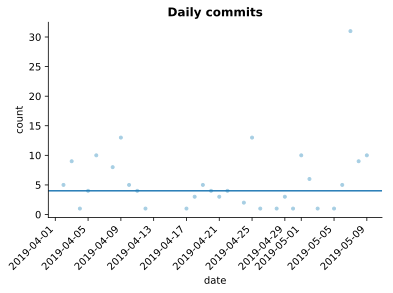

In [10]:
plot_scatter(commits, 'count')